# Titanic Project - Classification Prediction

### Importing the libraries to be used for the project

In [1]:
#!pip install missingpy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
#from missingpy import MissForest

### Data Exploration and Preprocessing

In [3]:
df_gender = pd.read_csv('gender_submission.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train['Survived'].value_counts()/df_train.shape[0]

Survived
0    0.616162
1    0.383838
Name: count, dtype: float64

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
def nulls_summary_table(df):
    """
    Returns a summary table showing null value counts and percentage
    
    Parameters:
    df (DataFrame): Dataframe to check
    
    Returns:
    null_values (DataFrame)
    """
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0]/len(df)
    null_values.columns = ['null_count','null_pct']
    return null_values

nulls_summary_table(df_train)

,null_count,null_pct
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [7]:
df_train.drop(labels=['PassengerId','Cabin','Name','Ticket', 'Age'], axis=1, inplace=True)

In [8]:
df_test.drop(labels=['PassengerId','Cabin','Name','Ticket', 'Age'], axis=1, inplace=True)

In [9]:
df_train.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [10]:
df_test.shape

(418, 6)

The below features hold very little predictive power, they hinder the models performance. Fare has very high correlation with Class, therefore I picked Class before it has a lower p-value than Fare against Survived

In [11]:
df_train['Sex'] = df_train['Sex'].map({'male':0, 'female':1}).astype('category')

In [12]:
df_test['Sex'] = df_test['Sex'].map({'male':0, 'female':1}).astype('category')

In [13]:
df_train['Embarked'] = df_train['Embarked'].map({'S':1,'C':2,'Q':3}).astype('category')

In [14]:
df_test['Embarked'] = df_test['Embarked'].map({'S':1,'C':2,'Q':3}).astype('category')

In [15]:
df_train['Parch'] = df_train['Parch'].map({0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1}).astype('category')

In [16]:
df_test['Parch'] = df_train['Parch'].map({0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1}).astype('category')

In [17]:
df_train.dropna(axis=0, inplace=True)

In [18]:
df_train.shape

(889, 7)

In [19]:
df_attributes = ['Pclass','Sex','Parch','SibSp', 'Fare','Embarked']
for parameter in df_attributes:
    pearson_coef, p_value = stats.pearsonr(df_train[parameter], df_train['Survived'])
    print(parameter)
    print('The Pearson Correlation Coefficient for ', parameter, ' is ', pearson_coef, 'with a P-value of P =', p_value)

Pclass
The Pearson Correlation Coefficient for  Pclass  is  -0.3355488593568243 with a P-value of P = 7.776916288566283e-25
Sex
The Pearson Correlation Coefficient for  Sex  is  0.5415849155511676 with a P-value of P = 6.68201214061486e-69
Parch
The Pearson Correlation Coefficient for  Parch  is  0.14932769913242963 with a P-value of P = 7.778277956728505e-06
SibSp
The Pearson Correlation Coefficient for  SibSp  is  -0.03403999879674883 with a P-value of P = 0.31067537341136364
Fare
The Pearson Correlation Coefficient for  Fare  is  0.25529046130469873 with a P-value of P = 1.0797887540540782e-14
Embarked
The Pearson Correlation Coefficient for  Embarked  is  0.10866867101787371 with a P-value of P = 0.0011739618827514076


In [20]:
df_train[['Pclass','Sex','Parch','SibSp', 'Fare','Embarked']].corr()

,Pclass,Sex,Parch,SibSp,Fare,Embarked
Pclass,1.000000,-0.127741,-0.029593,0.081656,-0.548193,0.043835
Sex,-0.127741,1.000000,0.249837,0.116348,0.179958,0.118593
Parch,-0.029593,0.249837,1.000000,0.461923,0.239264,-0.066939
SibSp,0.081656,0.116348,0.461923,1.000000,0.160887,-0.060606
Fare,-0.548193,0.179958,0.239264,0.160887,1.000000,0.063462
Embarked,0.043835,0.118593,-0.066939,-0.060606,0.063462,1.000000


In [21]:
df_train.drop(labels=['SibSp','Fare'], axis=1, inplace=True)

In [22]:
df_test.drop(labels=['SibSp','Fare'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

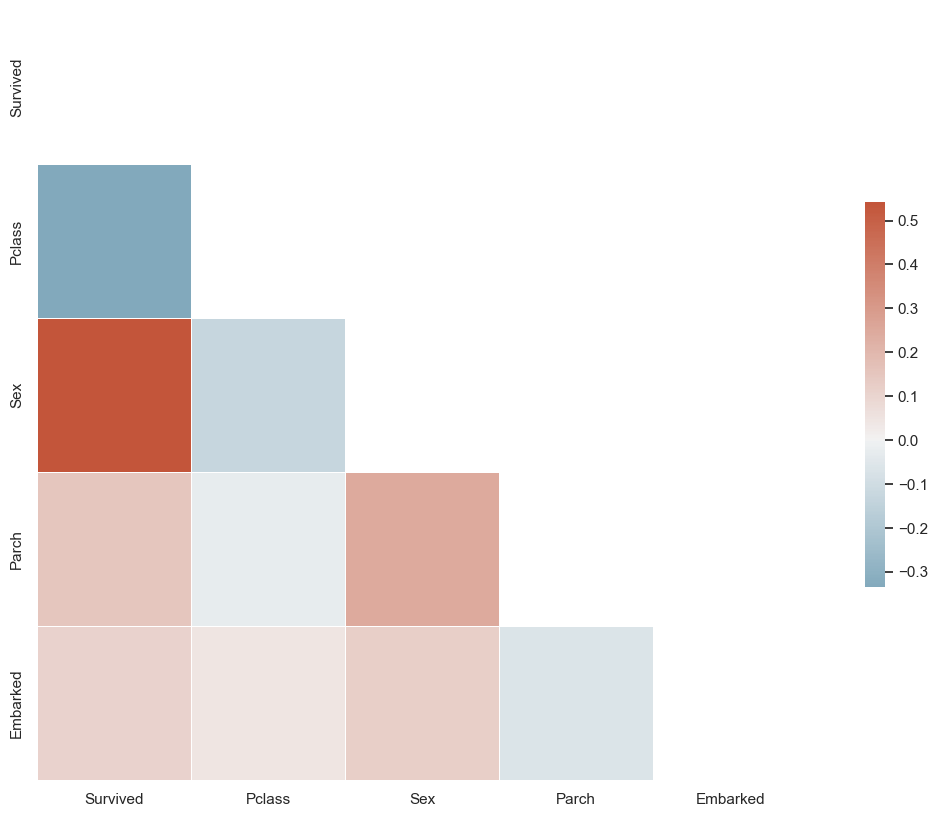

In [23]:
import numpy as np
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle (otherwise this looks like the square we had above and is redundant)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure 
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap (choose colors here)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio 
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":8})

#obviously many of thes variables are HIGHLY correlated. Something we may want to explore is why Average percentage viewed is negatively related to RPM

In [24]:
df = df_train.copy().astype('int32')

In [25]:
column_to_move = 'Survived'
current_position = df.columns.get_loc(column_to_move)
new_position = 4
column_to_move_series = df.pop(column_to_move)
df.insert(new_position, column_to_move, column_to_move_series)

df.head()

,Pclass,Sex,Parch,Embarked,Survived
0,3,0,0,1,0
1,1,1,0,2,1
2,3,1,0,1,1
3,1,1,0,1,1
4,3,0,0,1,0


In [26]:
classes = pd.get_dummies(df['Pclass'], dtype='int')
classes.columns = ['class_1','class_2','class_3']
classes.head()

,class_1,class_2,class_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [27]:
embarked = pd.get_dummies(df['Embarked'], dtype='int')
embarked.columns = ['EmbarkArea_1','EmbarkArea_2','EmbarkArea_3']
embarked.head()

,EmbarkArea_1,EmbarkArea_2,EmbarkArea_3
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [28]:
df = pd.concat([df, classes, embarked], axis=1)
df.head()

,Pclass,Sex,Parch,Embarked,Survived,class_1,class_2,class_3,EmbarkArea_1,EmbarkArea_2,EmbarkArea_3
0,3,0,0,1,0,0,0,1,1,0,0
1,1,1,0,2,1,1,0,0,0,1,0
2,3,1,0,1,1,0,0,1,1,0,0
3,1,1,0,1,1,1,0,0,1,0,0
4,3,0,0,1,0,0,0,1,1,0,0


#### Checkpoint for dataframe (df)

In [29]:
df_dummies = df.copy()

In [30]:
df_dummies.head()

,Pclass,Sex,Parch,Embarked,Survived,class_1,class_2,class_3,EmbarkArea_1,EmbarkArea_2,EmbarkArea_3
0,3,0,0,1,0,0,0,1,1,0,0
1,1,1,0,2,1,1,0,0,0,1,0
2,3,1,0,1,1,0,0,1,1,0,0
3,1,1,0,1,1,1,0,0,1,0,0
4,3,0,0,1,0,0,0,1,1,0,0


In [31]:
df_dummies.columns.values

array(['Pclass', 'Sex', 'Parch', 'Embarked', 'Survived', 'class_1',
       'class_2', 'class_3', 'EmbarkArea_1', 'EmbarkArea_2',
       'EmbarkArea_3'], dtype=object)

In [32]:
df_dummies.drop(labels=['Pclass','Embarked'], axis=1, inplace=True)

In [33]:
df_dummies.columns.values

array(['Sex', 'Parch', 'Survived', 'class_1', 'class_2', 'class_3',
       'EmbarkArea_1', 'EmbarkArea_2', 'EmbarkArea_3'], dtype=object)

In [34]:
reordered_columns = ['class_1', 'class_2', 'class_3', 'Sex', 'Parch', 
                     'EmbarkArea_1', 'EmbarkArea_2', 'EmbarkArea_3', 'Survived']

df_dummies = df[reordered_columns]

df_dummies.head()

,class_1,class_2,class_3,Sex,Parch,EmbarkArea_1,EmbarkArea_2,EmbarkArea_3,Survived
0,0,0,1,0,0,1,0,0,0
1,1,0,0,1,0,0,1,0,1
2,0,0,1,1,0,1,0,0,1
3,1,0,0,1,0,1,0,0,1
4,0,0,1,0,0,1,0,0,0


### Splitting the dataset into Training and Validation sets

In [35]:
X = df_dummies.iloc[:,:-1]

In [36]:
y = df_dummies.iloc[:,-1]

In [37]:
X.shape

(889, 8)

In [38]:
y.shape

(889,)

### Train Test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [40]:
print('The training set has: ', X_train.shape[0], ' rows of data.')
print('The test set has: ', X_test.shape[0], ' rows of data.')

The training set has:  711  rows of data.
The test set has:  178  rows of data.


## Creating of the Models

### Logistic Regression

In [41]:
lr_params ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [42]:
lr = LogisticRegression()
lr_cv = GridSearchCV(lr,lr_params, cv=10)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [43]:
print("tuned hpyerparameters :(best parameters) ",lr_cv.best_params_)
print("accuracy :",lr_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.780575117370892


In [44]:
lr_score = lr_cv.score(X_test, y_test)
lr_score

0.8089887640449438

In [45]:
lr_yhat=lr_cv.predict(X_test)
lr_cm = confusion_matrix(y_test, lr_yhat)
lr_cm

array([[96,  9],
       [25, 48]])

### Decision Tree Classifier

In [46]:
tree_params = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [47]:
tree_cv = GridSearchCV(tree, tree_params, cv=10)
tree_cv.fit(X_train, y_train)

/Users/boitumelomaseko/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/boitumelomaseko/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/boitumelomaseko/.local/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/boitumelomaseko/.local/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_para

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [48]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.8072769953051644


In [49]:
tree_score = tree_cv.score(X_test, y_test)
tree_score

0.8033707865168539

In [50]:
tree_yhat = tree_cv.predict(X_test)
tree_cm = confusion_matrix(y_test, tree_yhat)
tree_cm

array([[100,   5],
       [ 30,  43]])

### K Nearest Neighbor Classifier

In [51]:
knn_params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [52]:
knn_cv = GridSearchCV(KNN, knn_params, cv=10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [53]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree', 'n_neighbors': 4, 'p': 1}
accuracy : 0.8058489827856026


In [54]:
knn_score = knn_cv.score(X_test, y_test)
knn_score

0.8033707865168539

In [55]:
knn_yhat = knn_cv.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_yhat)
knn_cm

array([[102,   3],
       [ 32,  41]])

### Random Forest Classifier

In [56]:
rf_params = {'criterion': ['gini', 'entropy','log_loss'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

rf = RandomForestClassifier()

In [57]:
rf_cv = GridSearchCV(rf, rf_params, cv=10)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [58]:
print("tuned hpyerparameters :(best parameters) ",rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
accuracy : 0.8100743348982785


In [59]:
rf_score = rf_cv.score(X_test, y_test)
rf_score

0.8258426966292135

In [60]:
rf_yhat = rf_cv.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_yhat)
rf_cm

array([[102,   3],
       [ 28,  45]])

In [61]:
!pip install xgboost

In [62]:
from xgboost import XGBClassifier

In [63]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [64]:
xgb_score = xgb_classifier.score(X_test, y_test)
xgb_score

0.8033707865168539

In [65]:
xgb_yhat = xgb_classifier.predict(X_test)
xgb_cm = confusion_matrix(y_test, xgb_yhat)
xgb_cm

array([[100,   5],
       [ 30,  43]])

## Testing created Models against the test dataset

In [66]:
df_test.head()

,Pclass,Sex,Parch,Embarked
0,3,0,0,3
1,3,1,0,1
2,2,0,0,3
3,3,0,0,1
4,3,1,0,1


#### Create a dataframe checkpoint

In [67]:
df_test_dummies = df_test.copy()

#### Create dummy variable for Pclass

In [68]:
classes_test = pd.get_dummies(df_test_dummies['Pclass'], dtype='int')
classes_test.columns = ['class_1','class_2','class_3']
classes_test.head()

,class_1,class_2,class_3
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1


#### Create dummy variable for Embarked

In [69]:
embarked_test = pd.get_dummies(df_test_dummies['Embarked'], dtype='int')
embarked_test.columns = ['EmbarkArea_1','EmbarkArea_2','EmbarkArea_3']
embarked_test.head()

,EmbarkArea_1,EmbarkArea_2,EmbarkArea_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,1,0,0


#### Concatenate the 3 dataframes created

In [70]:
df_test_1 = pd.concat([df_test_dummies, classes_test, embarked_test], axis=1)
df_test_1.head()

,Pclass,Sex,Parch,Embarked,class_1,class_2,class_3,EmbarkArea_1,EmbarkArea_2,EmbarkArea_3
0,3,0,0,3,0,0,1,0,0,1
1,3,1,0,1,0,0,1,1,0,0
2,2,0,0,3,0,1,0,0,0,1
3,3,0,0,1,0,0,1,1,0,0
4,3,1,0,1,0,0,1,1,0,0


#### Drop the Pclass and Embarked variables

In [71]:
df_test_1.drop(labels=['Pclass','Embarked'], axis=1, inplace=True)

In [72]:
df_test_1.head()

,Sex,Parch,class_1,class_2,class_3,EmbarkArea_1,EmbarkArea_2,EmbarkArea_3
0,0,0,0,0,1,0,0,1
1,1,0,0,0,1,1,0,0
2,0,0,0,1,0,0,0,1
3,0,0,0,0,1,1,0,0
4,1,0,0,0,1,1,0,0


#### Reorder columns of test set

In [73]:
reordered_columns_test = ['class_1', 'class_2', 'class_3', 'Sex', 'Parch', 
                          'EmbarkArea_1', 'EmbarkArea_2', 'EmbarkArea_3']

df_test_1 = df_test_1[reordered_columns_test]

df_test_1.head()

,class_1,class_2,class_3,Sex,Parch,EmbarkArea_1,EmbarkArea_2,EmbarkArea_3
0,0,0,1,0,0,0,0,1
1,0,0,1,1,0,1,0,0
2,0,1,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0
4,0,0,1,1,0,1,0,0


In [74]:
df_gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [75]:
print(df_test_1.shape)
print(df_gender.shape)

(418, 8)
(418, 2)


#### Create a variable that will hold dataframe

In [76]:
X1 = df_test_1.iloc[:,:]

### Using the created models to predict new data

#### Logistic Regression Model

In [77]:
lr_yhat1 = lr_cv.predict(X1)
lr_yhat1

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

#### Decision Tree Classifier Model

In [78]:
tree_yhat1 = tree_cv.predict(X1)
tree_yhat1

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,

#### K Nearest Neighbor Classifier Model

In [79]:
knn_yhat1 = knn_cv.predict(X1)
knn_yhat1

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,

#### Random Forest Classifier Model

In [80]:
rf_yhat1 = rf_cv.predict(X1)
rf_yhat1

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

#### XGBoost Classifier Model

In [81]:
xgb_yhat1 = xgb_classifier.predict(X1)
xgb_yhat1

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,

### Checking relative accuracy against the training dataset

In [82]:
train_survivers = 0.383838 # Ratio of survivers in the training dataset

In [83]:
lr_survivers = np.sum(lr_yhat1)/rf_yhat1.shape[0] # Ratio of predicted survivers over the total number of rows
lr_survivers

0.29904306220095694

In [84]:
lr_score = np.sum(lr_survivers/train_survivers)*100
lr_score

77.9086651662829

In [85]:
tree_survivers = np.sum(tree_yhat1)/rf_yhat1.shape[0]
tree_survivers

0.2966507177033493

In [86]:
tree_score = np.sum(tree_survivers/train_survivers)*100
tree_score

77.28539584495263

In [87]:
knn_survivers = np.sum(knn_yhat1)/rf_yhat1.shape[0]
knn_survivers

0.25598086124401914

In [88]:
knn_score = np.sum(knn_survivers/train_survivers)*100
knn_score

66.68981738233816

In [89]:
rf_survivers = np.sum(rf_yhat1)/rf_yhat1.shape[0]
rf_survivers

0.2535885167464115

In [90]:
rf_score = np.sum(rf_survivers/train_survivers)*100
rf_score

66.0665480610079

In [91]:
xgb_survivers = np.sum(xgb_yhat1)/rf_yhat1.shape[0]
xgb_survivers

0.2966507177033493

In [92]:
xgb_score = np.sum(xgb_survivers/train_survivers)*100
xgb_score

77.28539584495263

In [94]:
df_gender['Survived'] = rf_yhat1
df_gender.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


### Create csv prediction file

In [95]:
df_gender.to_csv('titanic_predicted_survival_rf1.csv', index=False)

## Model prediction score on Kaggle

| Model                          | Score                  |
| ---:                           | ---:                   |
| Logistic Regression            | 75.12%                 |
| K Nearest Neighbor Classifier  | 77.03%                 | 
| Decision Tree Classifier       | 77.99%                 | 
| Random Forest Classifier       | 77.99%                 | 
| XGBoost Classifier             | 77.99%                 | 